### 一.简介
上一节已经介绍了提升树的算法流程，这一节只需要将下面的优化过程替换成求解具体的梯度即可：   

$$
w_m^*=arg\min_{w_m}\sum_{i=1}^NL(y_i,f_{m-1}(x_i)+T(x_i,w_m))
$$    

下面介绍一下常用的损失函数及其对应的负梯度   


（1）损失平方误差：   

$$
\frac{1}{2}(f_{m-1}(x)-y)^2
$$

对应的负梯度：   

$$
y-f_{m-1}(x)
$$   

（2）绝对误差损失：    

$$
\mid f_{m-1}(x)-y \mid
$$

对应的负梯度：   

$$
sign(y-f_{m-1}(x))
$$   

（3）Huber损失:   

$$
\left\{\begin{matrix}
\frac{1}{2}(f_{m-1}(x)-y)^2 & \mid y-f_{m-1}(x) \mid < \delta\\
\delta \mid y-f_{m-1}(x) \mid & otherwise
\end{matrix}\right.
$$

对应的负梯度：  

$$
\left\{\begin{matrix}
y-f_{m-1}(x) & \mid y-f_{m-1}(x) \mid < \delta\\
\delta\cdot sign(y-f_{m-1}(x)) & otherwise
\end{matrix}\right.
$$   

（4）分位数损失：   

$$
\left\{\begin{matrix}
\theta\mid y-f_{m-1}(x)\mid &  y>f_{m-1}(x)\\
(1-\theta)\mid y-f_{m-1}(x)\mid  & otherwise
\end{matrix}\right.
$$   

对应的负梯度：   

$$
\left\{\begin{matrix}
\theta &  y>f_{m-1}(x)\\
\theta-1  & otherwise
\end{matrix}\right.
$$   

注意： $0<\theta<1$

这四种损失函数的特点：  

（1）平方误差对$>1$的错误会进行放大，所以对离群点比较敏感；  

（2）而绝对误差可以避免这个问题，但在极小点附近，可能会由于梯度偏大而跨过极小点；  

（3）huber损失和分位数损失主要避免异常值的影响

接下来直接进行代码实现

### 二.代码实现

In [1]:
import os
os.chdir('../')
from ml_models.tree import CARTRegressor
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


"""
梯度提升模型，封装到ml_models.ensemble
"""


class GradientBoostingRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0, loss='ls', huber_threshold=1e-1,
                 quantile_threshold=0.5):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        :param loss:表示损失函数ls表示平方误差,lae表示绝对误差,huber表示huber损失,quantile表示分位数损失
        :param huber_threshold:huber损失阈值，只有在loss=huber时生效
        :param quantile_threshold损失阈值，只有在loss=quantile时生效
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = CARTRegressor(max_depth=2)
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)
        self.loss = loss
        self.huber_threshold = huber_threshold
        self.quantile_threshold = quantile_threshold

    def _get_gradient(self, y, y_pred):
        if self.loss == 'ls':
            return y - y_pred
        elif self.loss == 'lae':
            return (y - y_pred > 0).astype(int) * 2 - 1
        elif self.loss == 'huber':
            return np.where(np.abs(y - y_pred) > self.huber_threshold,
                            self.huber_threshold * ((y - y_pred > 0).astype(int) * 2 - 1), y - y_pred)
        elif self.loss == "quantile":
            return np.where(y - y_pred > 0, self.quantile_threshold, self.quantile_threshold-1)
        
    def fit(self, x, y):
        # 拟合第一个模型
        self.base_estimator[0].fit(x, y)
        y_pred = self.base_estimator[0].predict(x)
        new_y = self._get_gradient(y, y_pred)
        for index in range(1, self.n_estimators):
            self.base_estimator[index].fit(x, new_y)
            y_pred += self.base_estimator[index].predict(x) * self.learning_rate
            new_y = self._get_gradient(y, y_pred)

    def predict(self, x):
        return np.sum(
            [self.base_estimator[0].predict(x)] +
            [self.learning_rate * self.base_estimator[i].predict(x) for i in
             range(1, self.n_estimators - 1)] +
            [self.base_estimator[self.n_estimators - 1].predict(x)]
            , axis=0)

In [2]:
#构造数据
data = np.linspace(1, 10, num=100)
target1 = 3*data[:50] + np.random.random(size=50)*3#添加噪声
target2 = 3*data[50:] + np.random.random(size=50)*10#添加噪声
target=np.concatenate([target1,target2])
data = data.reshape((-1, 1))

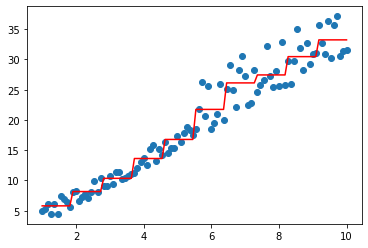

In [3]:
#同质
model=GradientBoostingRegressor(base_estimator=CARTRegressor(),n_estimators=3)
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')

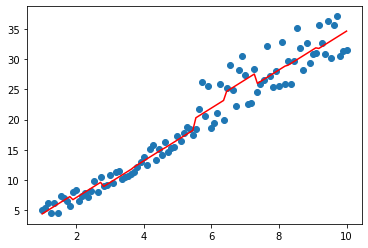

In [4]:
#异质
from ml_models.linear_model import LinearRegression
model=GradientBoostingRegressor(base_estimator=[LinearRegression(),CARTRegressor(),CARTRegressor()])
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')